# Entrainement d'un Classifieur en accord avec le robot PR2


### Importation des Bibliothèques

In [1]:
import pandas as pd
import numpy as np
from numpy import unique
from numpy import random
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline

import time
import zmq
import array
from utils import myfct,mydisplay
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

### Programme Principale 
Cette partie du programme doit être lancé avant la partie Segmentation en C++ et avant le programme sur l'ordinateur relié au robot PR2 par ROS en C++, le tout pour ne pas créer de problèmes en fonction des clients et des serveurs ZMQ

In [2]:
%%time


saving_for_experience = False
if (saving_for_experience):
    # Dossier dans le dossier Output ou nous allons sauvegarder nos données 
    #pour les réutiliser plus tards pour le plan d'experience
    saving_file = "env3_table3"   
    # Permet de ne pas écraser les fichiers préexistants si nous voulons
    # créer de nouvelles experiences pour un Batch
    starting_batch = 0



"""
Selection du model à utiliser, par défaut Random Forest est le plus efficace quand le taux d'erreur due à
l'effecteur du robot est inférieur à 20%. Cependant, grâce à l'algorithme d'oublie on est rarement au dessus de 
20% d'erreur dans notre base de donnée
"""
#model = SVC(kernel = 'rbf',probability=True,class_weight = 'balanced')
model = RandomForestClassifier()
#model = GaussianProcessRegressor(kernel = None)


"""
Hyperparamètres du batch d'experience:

nbBatch: 
Nombre d'"experience que l'on veux mener, en génerale, à par lors du plan d'experience, nbBatch = 1

nbScene: 
Nombre de fois que l'on va réorganiser les objets durant l'experience

nbIterPerScene: 
Nombre d'itération que l'on voudra effectuer entre 2 réorganisation des objets dans l'environnement
On obtient ainsi nbScene*nbIterPerScene interraction par experience
                
nb_model_for_removing_worst_SVP : 
Nombre de modèle utilisés pour l'algorithme d'oublie des outliers ttention car si le modèle demande 
beaucoup de calcule il est sans doute plus ertinent de baisser cette valeur
                            
proportion_of_completion: 
0.8 implique qu'au bout de 80% on fera le tri dans la base de données en utilisant l'algo 
d'oublie des Outliers. Dans tout les cas on refait le trie à la fin de l'eperience
                          
threshold_of_object: 
Taux d'objet dans la BDD au dela duquel on ne prends plus les SVP d'objets afin de ne pas 
déséquilibrer la base de données
"""
nbBatch = 1
nbScene = 2
nbIterPerScene = 4
nb_model_for_removing_worst_SVP = 1000
proportion_of_completion = 0.8#before eliminating the bad SVP
threshold_of_object = 0.42# taux d'objet dans la BDD au dela duquel on ne prends plus les SVP d'objets

batch_y_train_acc_exp = []
#batch_y_train_acc_true = []
batch_X_train_acc_rough = []
nb_interaction_reussi = []
selected_FPFH_number = 0

"""
Mise en place des serveur ZMQs pour la communication avec la partie segmentation en C++
Envoi de nbBatch, nbScene & nbIterPerScene pour l'initialisation
"""
context = zmq.Context()
socket = context.socket(zmq.REP)
socket.bind("tcp://*:5562")
message = socket.recv()
send_string = str(nbBatch)
socket.send_string(send_string)
message = socket.recv()
send_string = str(nbScene)
socket.send_string(send_string)
message = socket.recv()
send_string = str(nbIterPerScene)
socket.send_string(send_string)
print("data sent to C++")


"""
Début de l'experience
"""
for l in range (nbBatch):
    X_train_acc_rough = []
    #y_train_acc_true = []
    y_train_acc_exp = []
    nb_interaction_reussi_per_exp = 0;
    print("batch Numero ",l+1)
    for i in range(nbScene):
        for j in range(nbIterPerScene+1):
            
            if(j!=0):
                #old_y_train_true = np.copy(y_train_true)
                old_X_train_rough = np.copy(X_train_rough)
                old_selected_FPFH_number = selected_FPFH_number
                
                
            #On recupère les FPFH calculé par la partie Segmentation sur le Nuage de points récupéré sous Unity
            message = socket.recv()
            message1 = array.array('B',message)
            push_primitive_done,nb_svp_moved,FPFHL_preshape = message1[0],message1[1],message1[2:]
            print("push_primitive_done : ",push_primitive_done)

            if(nb_svp_moved!=0 and nb_svp_moved!=255):# si des SVP ont été déplacés et matchés:
                label = 1
                svp_moved_rough, FPFHL_preshape = message1[2:nb_svp_moved*2+2],message1[nb_svp_moved*2+2:]
                svp_moved = []
                accu_reachable = 0
                for k in range(nb_svp_moved):
                    #On recupère les Numéro des svp ayant bougés; il sont codés à l'aide de 2 char
                    num_svp = int(svp_moved_rough[2*k]*255 + svp_moved_rough[2*k+1])
                    if(num_svp<=min(len(old_X_train_rough), int(len(FPFHL_preshape)/49))):
                        svp_moved.append(int(svp_moved_rough[2*k]*255 + svp_moved_rough[2*k+1]))
                        print("svp_moved[k] :",svp_moved[accu_reachable])
                        accu_reachable +=1
            else:
                label = message1[1]#C'est le numéro du SVP d'arrière plan s'il n'y a pas eu de dépacement de SVP

            FPFH_LAB_L = np.reshape(FPFHL_preshape,(int(len(FPFHL_preshape)/49),49)).astype(int)
            X_train_rough = np.zeros((len(FPFH_LAB_L),48))
            #y_train_true = np.zeros(len(FPFH_LAB_L))
            for k in range(len(FPFH_LAB_L)):
                X_train_rough[k][:48] = FPFH_LAB_L[k][:48]
                #y_train_true[k] = FPFH_LAB_L[k][-1]
                 
            #On veux au moins trois FPFH d'objet avant d'utiliser la fonction d'acqusition
            #pour partir sur un modele relativement stable            
            if(sum(y_train_acc_exp) < 3 or (len(y_train_acc_exp) - sum(y_train_acc_exp)) < 3 or len(y_train_acc_exp) < 3):
                #print("a")
                if(j!=0):
                    #print("a1")
                    if(nb_svp_moved == 0 and push_primitive_done):
                        y_train_acc_exp.append(0)
                        #y_train_acc_true.append(int(old_y_train_true[old_selected_FPFH_number-1]))
                        X_train_acc_rough.append(old_X_train_rough[old_selected_FPFH_number-1])
                        nb_interaction_reussi_per_exp +=1
                        
                    elif(nb_svp_moved > 0 and push_primitive_done):
                        for k in range(len(svp_moved)):
                            num_sv = int(svp_moved[k])-1
                            y_train_acc_exp.append(1)
                            #y_train_acc_true.append(int(old_y_train_true[num_sv]))
                            #X_train_acc_rough.append(old_X_train_rough[num_sv])
                            #D'après les premiers tests en conditions réels, il semble plus pertinent
                            #de prendre les descripteurs du dernier nuage de points dans cette situation
                            #Cependant si les résultats ne sont pas bon, on peut reessayer de remplacer 
                            #X_train_rough par old_X_train_rough
                            X_train_acc_rough.append(X_train_rough[num_sv])
                            nb_interaction_reussi_per_exp +=1

                #On commence donc par selectionner nos SVP selon une loi uniforme
                selected_FPFH_number = int(random.uniform(0,len(X_train_rough)))
            
            #On entre dans ce else une fois qu"on a sufisement de données pour que le classifieur puisse utiliser la 
            #fonction d'acquisition pour la selection des futurs SVP sur lesquels activer la primitive de poussée
            else:
                if(j!=0):
                    if(nb_svp_moved == 0 and push_primitive_done):
                        y_train_acc_exp.append(0)
                        #y_train_acc_true.append(int(old_y_train_true[old_selected_FPFH_number-1]))
                        X_train_acc_rough.append(old_X_train_rough[old_selected_FPFH_number-1])
                        nb_interaction_reussi_per_exp +=1
                        
                        
                    elif(nb_svp_moved > 0 and push_primitive_done):
                        if(sum(y_train_acc_exp)/len(y_train_acc_exp)<threshold_of_object):#sinon on ne prends pas les SVP
                            for k in range(len(svp_moved)):
                                num_sv = int(svp_moved[k])-1
                                y_train_acc_exp.append(1)
                                #y_train_acc_true.append(int(old_y_train_true[num_sv]))
                                #X_train_acc_rough.append(old_X_train_rough[num_sv])
                                #D'après les premiers tests en conditions réels, il semble plus pertinent
                                #de prendre les descripteurs du dernier nuage de points dans cette situation
                                #Cependant si les résultats ne sont pas bon, on peut reessayer de remplacer 
                                #X_train_rough par old_X_train_rough
                                X_train_acc_rough.append(X_train_rough[num_sv])
                                nb_interaction_reussi_per_exp +=1
                                
                                
            
                #On réentraine le model avec toutes les données accumulées jusqu'a présent
                X_train_acc = myfct.normalize(X_train_acc_rough)
                model.fit(X_train_acc,y_train_acc_exp)  
                X_train = myfct.normalize(X_train_rough)
                #On prédit les probabilités d'appartenir à un objet ou au background de tout les SVP présent dans 
                #la scène car on en aura besoin pour la fonction d'acquisition
                preds_proba = model.predict_proba(X_train)
                #Fonction d'acquisition
                selected_FPFH_number = myfct.getRelevantFPFH(preds_proba,y_train_acc_exp,threshold_of_object)

            #Si on arrive à ce niveau du batch (ici 80%) on lance l'algo doublie des SVP non cohérents
            if(i*j==int(proportion_of_completion*nbScene*nbIterPerScene) and len(y_train_acc_exp)>20):
                X_train_acc_rough,y_train_acc_exp = myfct.forget_worst_sample2(
                    model,nb_model_for_removing_worst_SVP,X_train_acc_rough,y_train_acc_exp)
            
            #Envoie du SVP selectionné par la fonction d'acquisition à la partie Segmentation 
            socket.send_string(str(selected_FPFH_number))
            #if(label!=255):        
            #    print(" y_train_true",old_y_train_true[old_selected_FPFH_number])
                
    #on relance l'algo doublie des SVP non cohérents à la fin de l'experience
    if(len(y_train_acc_exp)>20):
        X_train_acc_rough,y_train_acc_exp = myfct.forget_worst_sample2(
                    model,nb_model_for_removing_worst_SVP,X_train_acc_rough,y_train_acc_exp) 
    
    #On récupère les échantillons, leur label déduit grace à l'effecteur
    batch_y_train_acc_exp.append(y_train_acc_exp)
    #batch_y_train_acc_true.append(y_train_acc_true)
    batch_X_train_acc_rough.append(X_train_acc_rough)
    #On recupère le nombre d'interraction réussi par experience
    nb_interaction_reussi.append(nb_interaction_reussi_per_exp)
    

    if(saving_for_experience):#Sauvegarde des données pour le plan d'experience
        
        path_y_train_acc_exp = "../Plan_exp/" + saving_file + "/batch_num_"+str(l+starting_batch)+"y_train_acc_exp"
        myfct.writePickler(path_y_train_acc_exp,y_train_acc_exp)
        #path_y_train_acc_true = "../Plan_exp/" + saving_file + "/batch_num_"+str(l+starting_batch)+"y_train_acc_true"
        #myfct.writePickler(path_y_train_acc_true,y_train_acc_true)
        path_X_train_acc_rough = "../Plan_exp/" + saving_file + "/batch_num_"+str(l+starting_batch)+"X_train_acc_rough"
        myfct.writePickler(path_X_train_acc_rough,X_train_acc_rough)


data sent to C++
batch Numero  1
push_primitive_done :  0
push_primitive_done :  0
push_primitive_done :  0
push_primitive_done :  0
push_primitive_done :  0
push_primitive_done :  0
push_primitive_done :  0
push_primitive_done :  1
svp_moved[k] : 340
svp_moved[k] : 339
svp_moved[k] : 338
svp_moved[k] : 337
svp_moved[k] : 336
svp_moved[k] : 335
svp_moved[k] : 334
svp_moved[k] : 323
svp_moved[k] : 322
svp_moved[k] : 319
svp_moved[k] : 318
svp_moved[k] : 315
svp_moved[k] : 314
svp_moved[k] : 303
svp_moved[k] : 300
svp_moved[k] : 295
svp_moved[k] : 131
svp_moved[k] : 125
svp_moved[k] : 124
svp_moved[k] : 122
svp_moved[k] : 121
svp_moved[k] : 120
svp_moved[k] : 119
svp_moved[k] : 113
svp_moved[k] : 111
svp_moved[k] : 107
svp_moved[k] : 103
svp_moved[k] : 102
svp_moved[k] : 101
svp_moved[k] : 96
svp_moved[k] : 94
svp_moved[k] : 93
svp_moved[k] : 88
svp_moved[k] : 87
svp_moved[k] : 79
svp_moved[k] : 75
svp_moved[k] : 284
svp_moved[k] : 283
svp_moved[k] : 24
svp_moved[k] : 20
svp_moved[k] : 1

In [3]:
for i in range(len(batch_y_train_acc_exp)):
    print("Batch Numero :",i)
    print("nb de données apres oublie :",len(batch_y_train_acc_exp[i]))
    print("nb d'interaction réussi lors du batch :",nb_interaction_reussi[i])

Batch Numero : 0
nb de données apres oublie : 69
nb d'interaction réussi lors du batch : 69


## Test de segmentation d'une scene

### Affichage en jaune des SVP définies comme appartenant à un objet avec une probabilité superieur à "treshold" par un classifieur entrainé sur la base de donnée accumulée lors de l'entrainement sur environnement réel avec le PR2

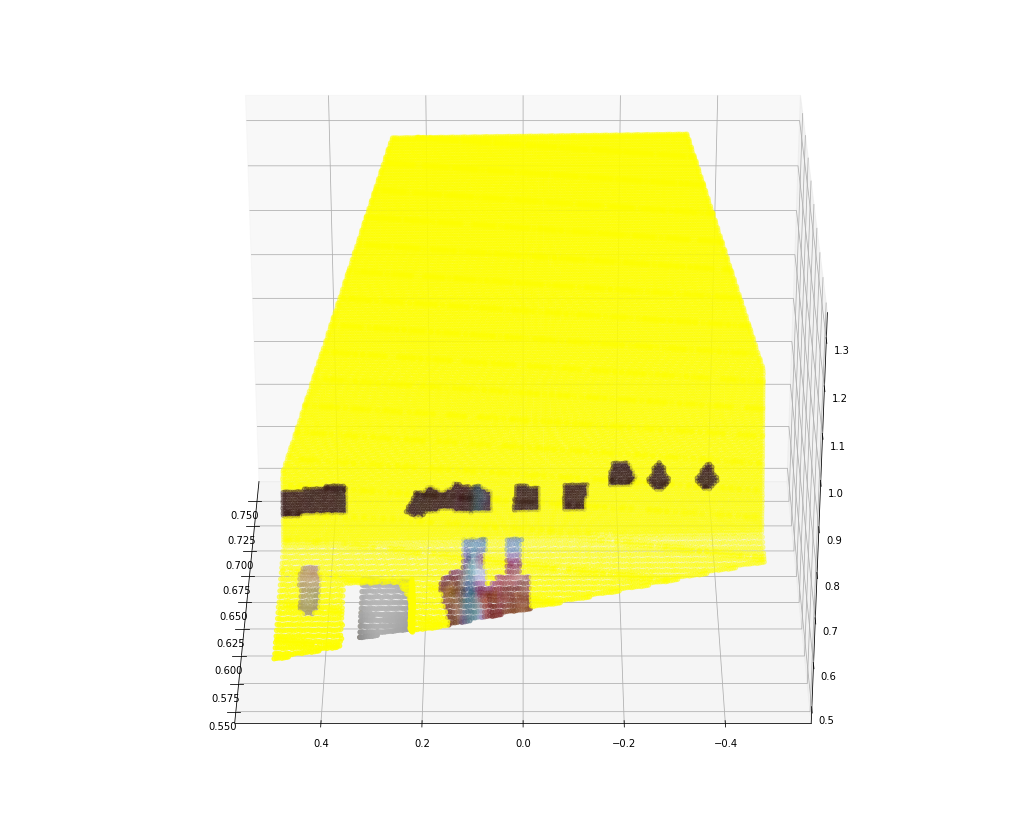

In [13]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report,confusion_matrix

model = RandomForestClassifier()
threshold = 0.7

#Nom de la scene que nous allons segmenter selon notre classifieur
nomDossier = "env_gazebo"
numIter = "2"
numeroDeScene = "1"
paths_to_output = "../outputs/"

#On entraine un modèle grace aux données recuperé lors du batch "numBatch"
numBatch = 0
batch_y_train_acc_exp[numBatch][0] = 0
model.fit(myfct.normalize(batch_X_train_acc_rough[numBatch][:]),batch_y_train_acc_exp[numBatch][:])
#model.fit(myfct.normalize(new_X),new_y)

sceneTest=pd.read_csv("../outputs/"+nomDossier+"/fpfh/fpfh_scene"+str(numeroDeScene)+"iter"+str(numIter)+".txt")
sceneTest.head()




#NORMALISER LES DONN2ES TESTS!!!!
scaler=StandardScaler() 
scaler.fit(sceneTest.drop('label',axis=1))
scaled_features = scaler.transform(sceneTest.drop('label',axis=1))
sceneTest_feat = pd.DataFrame(scaled_features,columns=sceneTest.columns[:-1])
sceneTest_feat.head()


testPrediction = model.predict(myfct.normalize(scaled_features)) 
testProba = model.predict_proba(myfct.normalize(scaled_features))
#print(confusion_matrix(y_test,pred))
testReality = np.array(sceneTest["label"])
testReality = np.concatenate(([0],testReality))

segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/vccs/vccs_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")



threshold = 0.99

X,Y,Z = [],[],[]
for i in range(len(segmented)):
    X.append(1.3-segmented[i][2]/pow(256,3))
    Y.append(-(segmented[i][1]/pow(256,3))+0.5)
    Z.append(1.3-segmented[i][0]/pow(256,3))
    
svp_obj = []
for i in range(len(testProba)):
    if(testProba[i][1]>threshold):
        svp_obj.append(i+1) 
        
colors = []
for i in range (len(segmented)):
    colors.append((segmented[i][3]/255, segmented[i][4]/255, segmented[i][5]/255))
    for j in range(len(svp_obj)):
        if(segmented[i][7] == svp_obj[j]):
            colors[-1] = (1.0, 1.0, 0.0)


colors = np.array(colors)

categories = []
for i in range(len(segmented)):
    categories.append(i)
    
fig = plt.figure(figsize = (18,15))
ax = fig.gca(projection='3d',proj_type = 'persp')

ax.view_init(30, 180)
#ax.zaxis_inverted
ax.scatter(X, Y, Z, c=colors[categories], marker='o')



In [5]:
#Donne les probabilités de chacun des SVP du nuage de points selectionné d'appartenir au background et à un objet 
#selon notre classifieur entrainé sur la base de donnée accumulé lors des tests sur robot réel
print(testProba) 

[[0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]

### Affichage du nuage de points avant Voxelisation, filtrage et découpage de la partie nous interessant

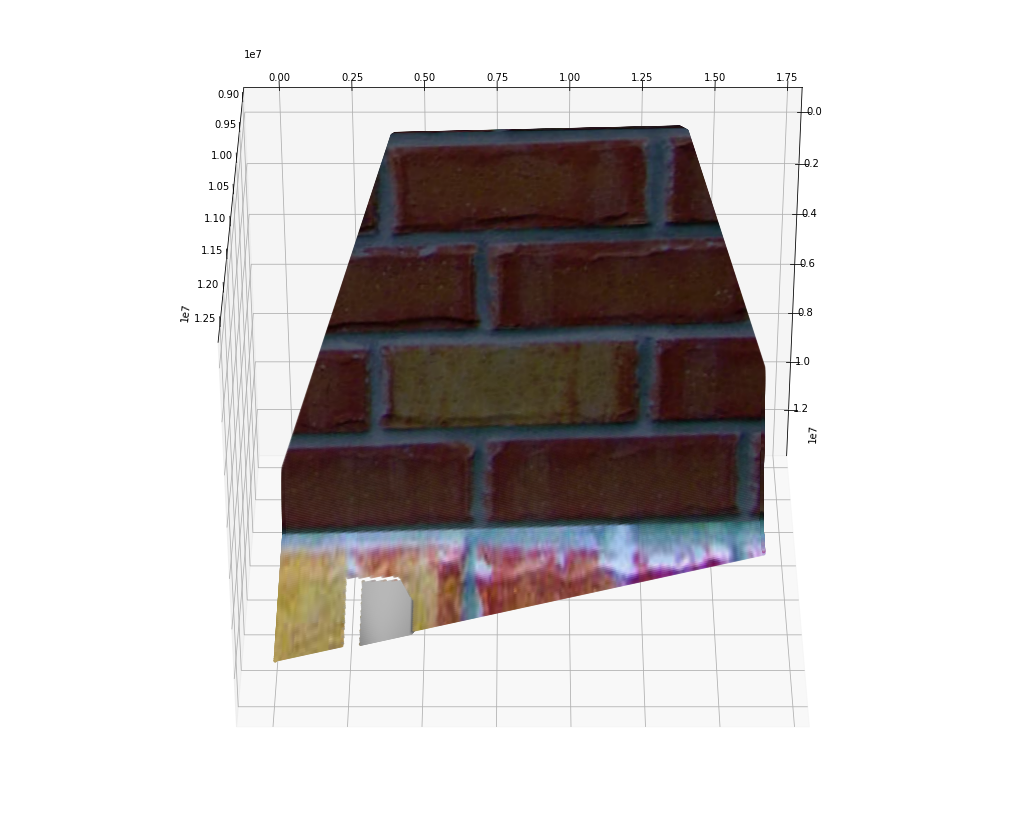

In [6]:


#segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/vccs/vccs_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")
segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/nuageDisplay/nuage_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")
svp_centroides = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/centroides/centroides_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")
sceneTest=pd.read_csv("../outputs/"+nomDossier+"/fpfh/fpfh_scene"+str(numeroDeScene)+"iter"+str(numIter)+".txt")
X1,Y1,Z1,X2,Y2,Z2 = [],[],[],[],[],[]
for i in range(len(segmented)):
    X1.append(segmented[i][0])
    Y1.append(segmented[i][1])
    Z1.append(segmented[i][2])
    
for i in range(len(svp_centroides)):
    if(sceneTest["label"][i] == 1):
        X2.append(svp_centroides[i][0])
        Y2.append(svp_centroides[i][1])
        Z2.append(svp_centroides[i][2])
        
    
svp_obj = []
for i in range(len(testPrediction)):
    if(testPrediction[i]):
        svp_obj.append(i+1) 
        
colors = []
for i in range (len(segmented)):
    colors.append((segmented[i][3]/255, segmented[i][4]/255, segmented[i][5]/255))
    #for j in range(len(svp_obj)):
        #if(segmented[i][7] == svp_obj[j]):
        #    colors[-1] = (1.0, 1.0, 0.0)


colors = np.array(colors)

categories = []
for i in range(len(segmented)):
    categories.append(i)
    
fig = plt.figure(figsize = (18,15))
ax = fig.gca(projection='3d')
ax.view_init(90+35, 0)
ax.scatter(X1, Y1, Z1, c=colors[categories], marker='.')
ax.scatter(X2, Y2, Z2, c='yellow',linewidths = 4, marker='.')

### Affichage de l'environnement selectionné avec les coordonnées réels avec une couleur différente pour chaque supervoxels

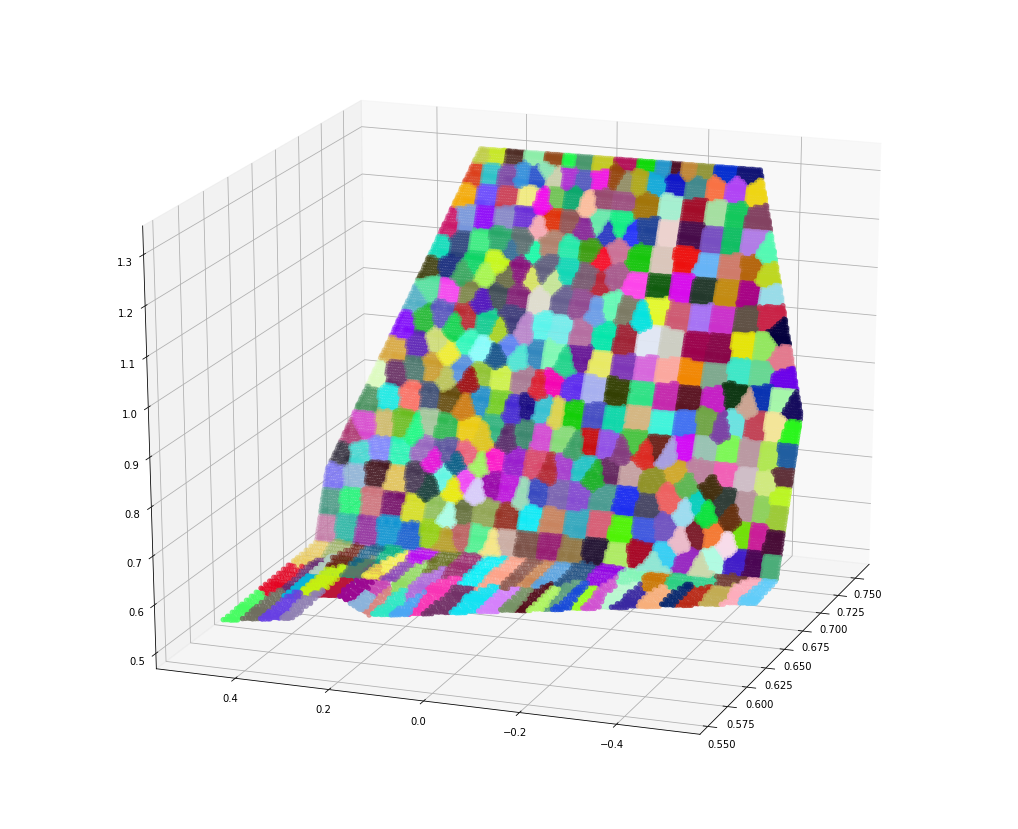

In [82]:
segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/vccs/vccs_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")

X,Y,Z = [],[],[]
for i in range(len(segmented)):
    X.append(1.3-segmented[i][2]/pow(256,3))
    Y.append(0.5-(segmented[i][1]/pow(256,3)))
    Z.append(1.3-segmented[i][0]/pow(256,3))
    
colors = []
for i in range (3000):
    colors.append((random.uniform(0,1), random.uniform(0,1), random.uniform(0,1), 1.0))
colors = np.array(colors)

categories = []
for i in range(len(segmented)):
    categories.append(int(segmented[i][-1]))
    
fig = plt.figure(figsize = (18,15))
ax = fig.gca(projection='3d')
ax.view_init(20, 200)
ax.scatter(X, Y, Z, c=colors[categories], marker='o')

### Affichage de l'environnement selectionné avec les coordonnées réels avec une couleur différente pour chaque supervoxels ainsi que leurs numero allant de 1 à N

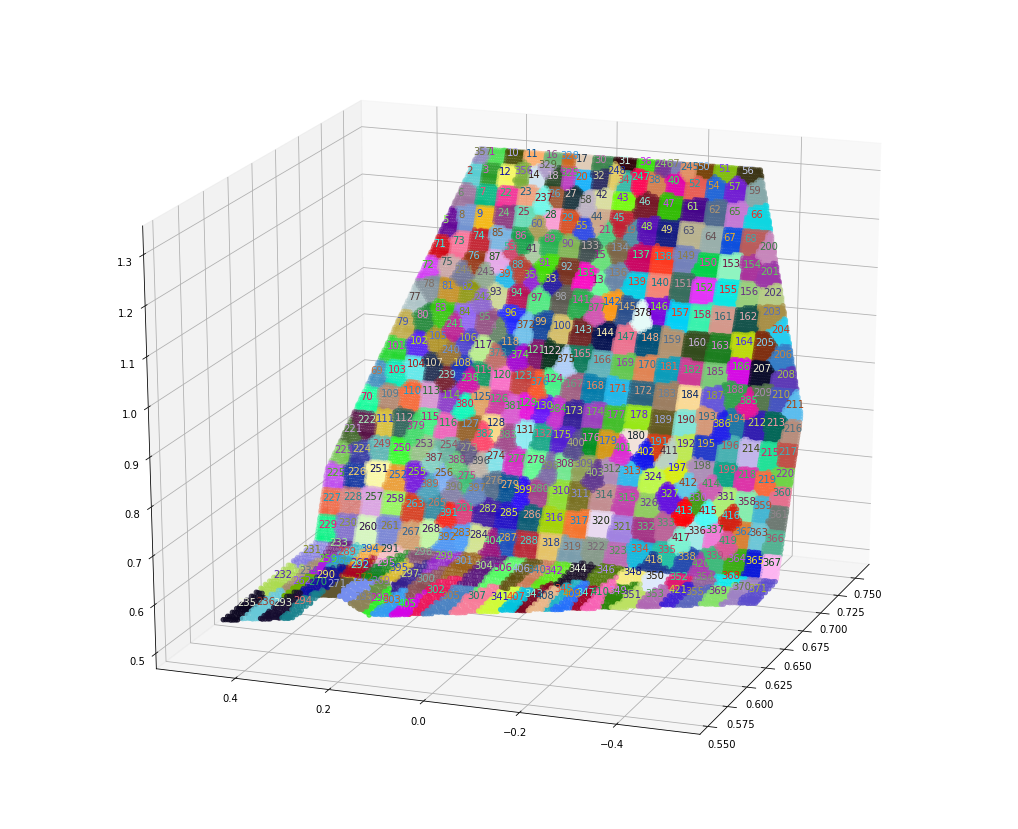

In [83]:
segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/vccs/vccs_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")

first_time = np.ones(segmented[-1][-1])
X,Y,Z = [],[],[]
coords = np.zeros((segmented[-1][-1],4))

for i in range(len(segmented)):
    X.append(1.3-segmented[i][2]/pow(256,3))
    Y.append(0.5-(segmented[i][1]/pow(256,3)))
    Z.append(1.3-segmented[i][0]/pow(256,3))
    
colors = []
for i in range (3000):
    colors.append((random.uniform(0,1), random.uniform(0,1), random.uniform(0,1), 1.0))
colors = np.array(colors)

fig = plt.figure(figsize = (18,15))
ax = fig.gca(projection='3d')
ax.view_init(20, 200)

categories = []
for i in range(len(segmented)):
    categories.append(int(segmented[i][-1]))
    coords[segmented[i][-1]-1][0] += 1.3-segmented[i][2]/pow(256,3)
    coords[segmented[i][-1]-1][1] += 0.5-(segmented[i][1]/pow(256,3))
    coords[segmented[i][-1]-1][2] += 1.3-segmented[i][0]/pow(256,3)
    coords[segmented[i][-1]-1][3] += 1

    
for i in range (len(coords)):
    coords[i][0] /= coords[i][3]
    coords[i][1] /= coords[i][3]
    coords[i][2] /= coords[i][3]
    color = (1-colors[i+1][0],1-colors[i+1][1],1-colors[i+1][2])
    ax.text(coords[i][0]+0.001, coords[i][1]+0.020,coords[i][2]+0.001,str(i+1),size=10,color=color)

    
ax.scatter(X, Y, Z, c=colors[categories], marker='o')

In [52]:
len(svp_centroides)

421

### Affichage de l'environnement selectionné avec les coordonnées réels

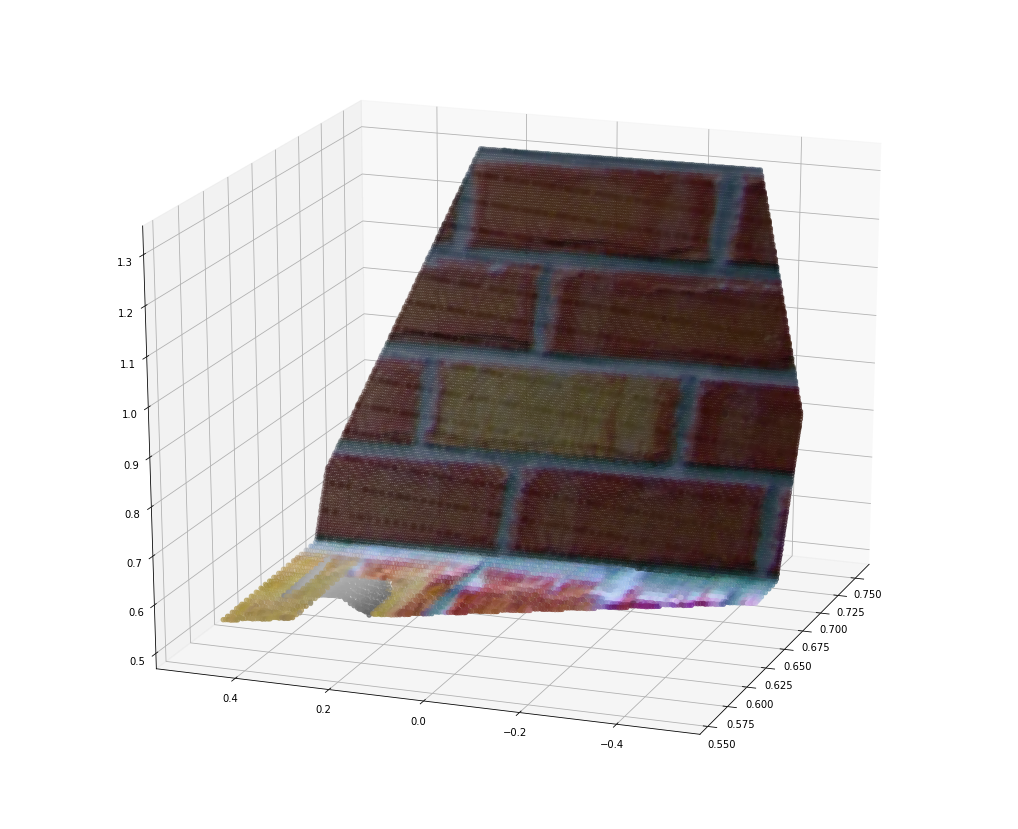

In [8]:


sceneTest=pd.read_csv("../outputs/"+nomDossier+"/fpfh/fpfh_scene"+str(numeroDeScene)+"iter"+str(numIter)+".txt")

scaler=StandardScaler() 
scaler.fit(sceneTest.drop('label',axis=1))
scaled_features = scaler.transform(sceneTest.drop('label',axis=1))
sceneTest_feat = pd.DataFrame(scaled_features,columns=sceneTest.columns[:-1])


sv_obj = []
for i in range(len(sceneTest)):
    if(sceneTest["label"][i] == 1):
        sv_obj.append(i+1)
#sv_moved = [846,242,838,247,502,299,567,248,500,246,536,600]#true_numbers#[]
#for i in range(len(y_train_true)):
#    if(y_train_true[i] == 1):
#        sv_moved.append(i+1)

segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/vccs/vccs_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")

X,Y,Z = [],[],[]
for i in range(len(segmented)):
    X.append(1.3-segmented[i][2]/pow(256,3))
    Y.append(-(segmented[i][1]/pow(256,3))+0.5)
    Z.append(1.3-segmented[i][0]/pow(256,3))
    #Z.append(segmented[i][2]*256*256+segmented[i][5]*256+segmented[i][4])
    
colors = []
for i in range (len(segmented)):
    colors.append((segmented[i][3]/256, segmented[i][4]/256, segmented[i][5]/256))
    for j in range(len(sv_obj)):
        if(segmented[i][7] == svp_moved[j]):
            colors[-1] = (1, 1, 0)


colors = np.array(colors)

categories = []
for i in range(len(segmented)):
    categories.append(i)
    
fig = plt.figure(figsize = (18,15))

ax = fig.gca(projection='3d')

#ax.view_init(-90, 270)
#ax.view_init(90-90, 180)
ax.view_init(20, 200)
#ax.view_init(0, 270)
ax.scatter(X, Y, Z, c=colors[categories], marker='o')

In [9]:
nomDossier = "env_gazebo"
numIter = "2"
numeroDeScene = "1"
paths_to_output = "../outputs/"

### Affichage permettant de mettre en évidence les SVPs inclus dans la liste "svp_moved". Cela peut etre utile pour vérifier que les coordonnées du robot soient identiques à celles que nous utilisons mais aussi pour la labelisation manuelle qui sera necessaire lors du plan d'experience

In [84]:
svp_moved = [421]

36


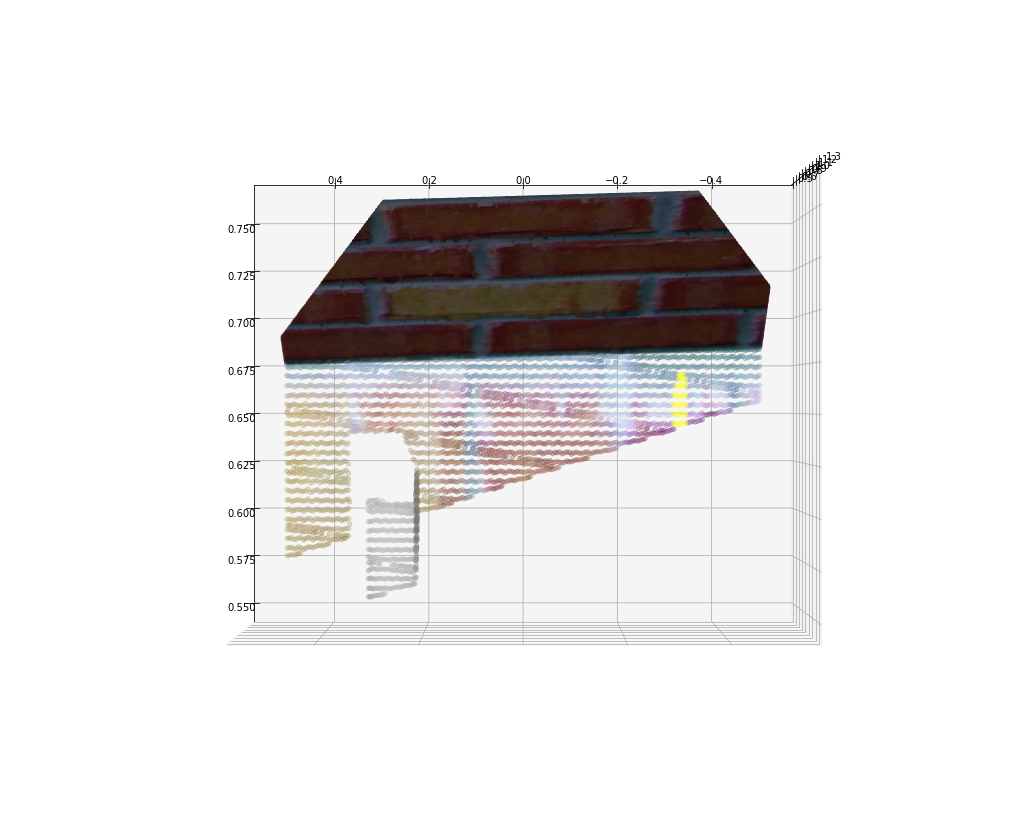

In [85]:
segmented = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/vccs/vccs_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")
svp_centroides = mydisplay.read_xyzrgbls(paths_to_output+str(nomDossier)+"/centroides/centroides_scene"+str(numeroDeScene)+"iter"+numIter+".xyzrgbls")



X,Y,Z = [],[],[]
for i in range(len(segmented)):
    X.append(1.3-segmented[i][2]/pow(256,3))
    Y.append(-(segmented[i][1]/pow(256,3))+0.5)
    Z.append(1.3-segmented[i][0]/pow(256,3))
    
colors = []
accu = 0
for i in range (len(segmented)):
    colors.append((segmented[i][3]/256, segmented[i][4]/256, segmented[i][5]/256))
    for j in range(len(svp_moved)):
        if(segmented[i][7] == svp_moved[j]):
            colors[-1] = (1, 1, 0)
            accu +=1
print(accu)

colors = np.array(colors)

categories = []
for i in range(len(segmented)):
    categories.append(i)
    
fig = plt.figure(figsize = (18,15))

ax = fig.gca(projection='3d')

#ax.view_init(-90, 270)
#ax.view_init(90-90, 180)
#ax.view_init(20, 200)
ax.view_init(90, 180)#Différents point de vue sur l'environnement du robot
ax.scatter(X, Y, Z, c=colors[categories], marker='o')

In [18]:
"""
from PIL import Image, ImageFilter

img = Image.open("Objects.png")
width, height = img.size
WHITE_THRESHOLD = 5
White = (255, 255, 255)
BLUE = (52, 152, 219)
for x in range(1,width-1):
    for y in range(1,height-1):
        pixel = img.getpixel((x, y))
        if (not(pixel[0]<0 and pixel[1]<0 and pixel[2]<1)):
            img.putpixel((x-1, y), pixel)
            img.putpixel((x-2, y), pixel)
            img.putpixel((x-1, y-1), pixel)
img.show()
"""

'\nfrom PIL import Image, ImageFilter\n\nimg = Image.open("Objects.png")\nwidth, height = img.size\nWHITE_THRESHOLD = 5\nWhite = (255, 255, 255)\nBLUE = (52, 152, 219)\nfor x in range(1,width-1):\n    for y in range(1,height-1):\n        pixel = img.getpixel((x, y))\n        if (not(pixel[0]<0 and pixel[1]<0 and pixel[2]<1)):\n            img.putpixel((x-1, y), pixel)\n            img.putpixel((x-2, y), pixel)\n            img.putpixel((x-1, y-1), pixel)\nimg.show()\n'